In [1]:
import xgboost
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from matplotlib import pyplot
from xgboost import plot_importance
from pymlx import *
from catboost import CatBoostRegressor


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
def compute_mae(model, x, y):
    forecasts = model.predict(x)
#     forecasts = forecasts.reshape(forecasts.shape[0],dense)
    forecasts = (forecasts * std_y) + mean_y
    y_denom = (y * std_y) + mean_y
    result = mean_absolute_error(y_pred=forecasts, y_true=y_denom)
    return result

def compute_mape_centerScale(model, x, y):
    forecasts = model.predict(x)
#     forecasts = forecasts.reshape(forecasts.shape[0],1)
    forecasts = (forecasts * std_y) + mean_y
    y_denom = (y * std_y) + mean_y
    sub_result = np.abs((y_denom - forecasts) / y_denom )
    result = (np.mean(sub_result))
    return result


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def xgb_iter(X, y, params, test_size=0.2, itera=100):
    mape_list, mae_list, rmse_list = [], [], []
    for i in range(itera):
        # split data into train and test sets
        test_size = 0.20
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        #### normalize

        mean_X = X_train.mean(axis=0)
        std_X = X_train.std(axis=0)

        X_train = (X_train - mean_X) / std_X
        X_test = (X_test - mean_X) / std_X

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        mean_y = y_train.mean(axis=0)
        std_y = y_train.std(axis=0)

        y_train = (y_train - mean_y) / std_y
        y_test = (y_test - mean_y) / std_y

        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        model = XGBRegressor(**params, silent=True);
        model.fit(X_train, y_train, verbose=1)

        # make predictions for test data
        y_pred = model.predict(X_test)
        y_pred_inv = (y_pred * std_y) + mean_y
        y_test_inv = (y_test * std_y) + mean_y

        # y_pred_inv
        mape_list.append(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv))
        mae_list.append(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv))
        rmse_list.append(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv)))
    return(mape_list, mae_list, rmse_list)

In [13]:
# ndre_data = pd.read_csv('../HydroSatML/data/final_join_subbed_missing_soilM.csv')
# ndre_data_sub_30 = pd.read_csv('../HydroSatML/data/final_join_subbed_bare_soil.csv')
# ndre_data_sub_40 = pd.read_csv('../HydroSatML/data/final_join_subbed_bare_soil_40.csv')
ndre_data_lag_40 = pd.read_csv('../HydroSatML/data/final_join_subbed_bare_soil_with_lag_40.csv')

In [14]:
ndre_data_lag_40.columns

Index(['field', 'average_adjacent', 'stdev_adjacent', 'sensor', 'date',
       'sensor_full_name', 'depth_1', 'depth_2', 'depth_3', 'precip.cm',
       'tair.C', 'rh.pct', 'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'year',
       'sand_1', 'sand_2', 'sand_3', 'silt_1', 'silt_2', 'silt_3', 'clay_1',
       'clay_2', 'clay_3', 'l3_depth_1', 'l3_depth_2', 'l3_depth_3',
       'l5_depth_1', 'l5_depth_2', 'l5_depth_3', 'l7_depth_1', 'l7_depth_2',
       'l7_depth_3', 'avg_soilM', 'avg_soilM_l3', 'avg_soilM_l5',
       'avg_soilM_l7', 'avg_clay', 'avg_sand', 'avg_silt'],
      dtype='object')

In [5]:
# keep_cols = ['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
#              'irradiance.w_per_m.2', 'sand_1', 'sand_2', 'sand_3', 'silt_1', 'silt_2', 'silt_3', 'clay_1', 
#              'clay_2', 'clay_3']
keep_cols = ['avg_soilM_l3', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']

# dataset = ndre_data_lag_40[keep_cols]

X = dataset.iloc[:,1:]
X = X.values

y = dataset.iloc[:,0]
y = y.values

In [55]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#### normalize

In [56]:
mean_X = X_train.mean(axis=0)
std_X = X_train.std(axis=0)

X_train = (X_train - mean_X) / std_X
X_test = (X_test - mean_X) / std_X

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

mean_y = y_train.mean(axis=0)
std_y = y_train.std(axis=0)

y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [57]:
print(X_train.shape)
print(X_test.shape)
print('')
print(y_train.shape)
print(y_test.shape)

(299, 9)
(75, 9)

(299,)
(75,)


In [80]:
model = XGBRegressor()

n_estimators = range(50, 5000, 50)
max_depth = range(3,15,1)
# learning_rate = [10**k for k in range(-5, -0)]
learning_rate = np.arange(0,0.301,0.01)
min_child_weight = range(1,15,1)
gamma = np.arange(0,0.5,0.001)
subsample = np.arange(0,1.01,.01)
colsample_bytree = np.arange(0.5,1.01,0.01)
colsample_bylevel = np.arange(0.5,1.01,0.01)
reg_alpha = np.arange(0,0.1,0.001)


param_grid = dict(n_estimators = n_estimators,
                  max_depth = max_depth,
                  min_child_weight = min_child_weight,
                  gamma = gamma,
                  learning_rate = learning_rate,
                  subsample = subsample,
                  colsample_bytree = colsample_bytree,
                  reg_alpha = reg_alpha)

start_timing()
sweeper = random_sweep(
    X_train, y_train, 
    model, param_grid,
    scoring=compute_mape_centerScale, 
    n_iter=1000, n_jobs=7, refit=False, cv=3, verbose=1)
report_timing()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.2s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   13.8s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   36.7s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  4.2min


Elapsed: 5.2 minutes


[Parallel(n_jobs=7)]: Done 3000 out of 3000 | elapsed:  5.2min finished


In [81]:
sweep_stats(sweeper)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,Score,Std,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,subsample
0,0.224853,0.045165,0.80,0.459,0.29,12,2,4800,0.043,0.04
1,0.207627,0.015899,0.92,0.135,0.19,14,14,4350,0.086,0.01
2,0.207627,0.015899,0.77,0.454,0.03,10,10,4650,0.053,0.00
3,0.207627,0.015899,0.70,0.427,0.00,8,12,1250,0.086,0.37
4,0.207627,0.015899,0.81,0.333,0.00,4,5,2050,0.020,0.01
5,0.207627,0.015899,0.93,0.446,0.05,13,13,4500,0.082,0.00
6,0.207627,0.015899,0.71,0.009,0.08,14,13,3950,0.059,0.01
7,0.207627,0.015899,0.58,0.467,0.13,10,9,4350,0.011,0.00
8,0.207627,0.015899,0.77,0.210,0.17,13,2,3300,0.015,0.00
9,0.207627,0.015899,0.97,0.177,0.26,12,12,2450,0.085,0.00


### Best params so far

In [58]:
model = XGBRegressor(colsample_bytree=0.78, gamma=0.085, learning_rate=0.12, max_depth=4, 
                     min_child_weight=5, n_estimators=2200, reg_alpha = 0.01, subsample=0.98)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.78, gamma=0.085, learning_rate=0.12,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=2200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.98)

### Best params for tuning with lag_3day as the response

In [102]:
# model = XGBRegressor(colsample_bytree=0.57, gamma=0.031, learning_rate=0.08, max_depth=3, 
#                      min_child_weight=3, n_estimators=2000, reg_alpha = 0.006, subsample=0.19)

# model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.57, gamma=0.031, learning_rate=0.08,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=2000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.006, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.19)

#### Using sand silt and clay and three depths; real time soilM

In [106]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.3f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.3f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.3f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.079
MAE: 0.017
RMSE: 0.024


#### Using average sand, silt, clay; real time soilM

In [30]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.0848
MAE: 0.0175
RMSE: 0.0259


#### Average sand, silt, clay, soilM lag 3

In [83]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.3f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.3f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.3f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.074
MAE: 0.017
RMSE: 0.025


In [21]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.0721
MAE: 0.0163
RMSE: 0.0227


#### Average sand, silt, clay, soilM lag 5

In [65]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.3f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.3f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.3f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.073
MAE: 0.017
RMSE: 0.023


In [51]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.0726
MAE: 0.0168
RMSE: 0.0238


#### Average sand, silt, clay, soilM lag 7

In [73]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.3f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.3f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.3f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.072
MAE: 0.016
RMSE: 0.023


In [59]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.0720
MAE: 0.0165
RMSE: 0.0231


### Iterate to get a distribution

In [7]:
params = dict(colsample_bytree=0.78, gamma=0.085, learning_rate=0.12, max_depth=4, 
                     min_child_weight=5, n_estimators=2200, reg_alpha = 0.01, subsample=0.98)

### 500 iteration 0 day lag

In [33]:
keep_cols = ['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']

dataset = ndre_data_lag_40[keep_cols]

X = dataset.iloc[:,1:]
X = X.values
y = dataset.iloc[:,0]
y = y.values

mape0, mae0, rmse0 = xgb_iter(X, y, itera=500, params=params)

In [34]:
'MAPE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mape0)), np.std(np.asarray(mape0)))
'MAE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mae0)), np.std(np.asarray(mae0)))
'RMSE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(rmse0)), np.std(np.asarray(rmse0)))

'MAPE: 0.1019 ± 0.0148'

'MAE: 0.0209 ± 0.0026'

'RMSE: 0.0316 ± 0.0045'

### 500 iterations 3 day lag

In [49]:
keep_cols = ['avg_soilM_l3', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']
keep_cols_lasso = ['avg_soilM_l3', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
                   'avg_sand', 'avg_silt']
dataset = ndre_data_lag_40[keep_cols_lasso]

X = dataset.iloc[:,1:]
X = X.values
y = dataset.iloc[:,0]
y = y.values

mape3_lass, mae3_lass, rmse3_lass = xgb_iter(X, y, itera=500, params=params)

In [36]:
'MAPE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mape3)), np.std(np.asarray(mape3)))
'MAE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mae3)), np.std(np.asarray(mae3)))
'RMSE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(rmse3)), np.std(np.asarray(rmse3)))

'MAPE: 0.0758 ± 0.0097'

'MAE: 0.0175 ± 0.0021'

'RMSE: 0.0252 ± 0.0035'

In [50]:
'MAPE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mape3_lass)), np.std(np.asarray(mape3_lass)))
'MAE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mae3_lass)), np.std(np.asarray(mae3_lass)))
'RMSE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(rmse3_lass)), np.std(np.asarray(rmse3_lass)))

'MAPE: 0.0774 ± 0.0097'

'MAE: 0.0179 ± 0.0021'

'RMSE: 0.0257 ± 0.0033'

### 500 iterations 5 day lag

In [37]:
keep_cols = ['avg_soilM_l5', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']

dataset = ndre_data_lag_40[keep_cols]

X = dataset.iloc[:,1:]
X = X.values
y = dataset.iloc[:,0]
y = y.values

mape5, mae5, rmse5 = xgb_iter(X, y, itera=500, params=params)

In [38]:
'MAPE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mape5)), np.std(np.asarray(mape5)))
'MAE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mae5)), np.std(np.asarray(mae5)))
'RMSE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(rmse5)), np.std(np.asarray(rmse5)))

'MAPE: 0.0775 ± 0.0102'

'MAE: 0.0181 ± 0.0022'

'RMSE: 0.0261 ± 0.0036'

### 500 iterations 7 day lag

In [39]:
keep_cols = ['avg_soilM_l7', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']

dataset = ndre_data_lag_40[keep_cols]

X = dataset.iloc[:,1:]
X = X.values
y = dataset.iloc[:,0]
y = y.values

mape7, mae7, rmse7 = xgb_iter(X, y, itera=500, params=params)

In [40]:
'MAPE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mape7)), np.std(np.asarray(mape7)))
'MAE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(mae7)), np.std(np.asarray(mae7)))
'RMSE: {0:0.4f} ± {1:0.4f}'.format(np.mean(np.asarray(rmse7)), np.std(np.asarray(rmse7)))

'MAPE: 0.0760 ± 0.0103'

'MAE: 0.0179 ± 0.0022'

'RMSE: 0.0260 ± 0.0036'

### Create dataframe

In [46]:
results_df = pd.DataFrame({'soilM_mae': mae0, 'soilM_mape': mape0, 'soilM_rmse': rmse0,
                          'soilM_l3_mae': mae3, 'soilM_l3_mape': mape3, 'soilM_l3_rmse': rmse3,
                          'soilM_l5_mae': mae5, 'soilM_l5_mape': mape5, 'soilM_l5_rmse': rmse5,
                          'soilM_l7_mae': mae7, 'soilM_l7_mape': mape7, 'soilM_l7_rmse': rmse7})

In [48]:
results_df.to_csv('results_df_xgboost.csv')

# CATBOOST

In [154]:
cat_model = CatBoostRegressor()

iterations = range(50, 1000, 50)
depth = range(4,10,1)
eval_metric = ['MAE']
od_type = ['Iter']
learning_rate = np.arange(0,0.301,0.01)
l2_leaf_reg = np.arange(0,1,0.001)
bagging_temperature = np.arange(0,1,0.1)
logging_level=['Silent']


param_grid = dict(iterations = iterations,
                  depth = depth,
                  eval_metric=eval_metric,
                  od_type=od_type,
                  l2_leaf_reg=l2_leaf_reg,
                  learning_rate = learning_rate, 
                  logging_level=logging_level)

start_timing()
sweeper = random_sweep(
    X_train, y_train, 
    cat_model, param_grid,
    scoring=compute_mape_centerScale, 
    n_iter=1000, n_jobs=7, refit=False, cv=3, verbose=1)
report_timing()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   36.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  5.3min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 12.0min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 21.6min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 35.1min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 47.3min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 63.2min


Elapsed: 77 minutes


[Parallel(n_jobs=7)]: Done 3000 out of 3000 | elapsed: 77.5min finished


In [155]:
sweep_stats(sweeper)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,Score,Std,depth,eval_metric,iterations,l2_leaf_reg,learning_rate,logging_level,od_type
0,0.204099,0.013392,8,MAE,100,0.647,0.00,Silent,Iter
1,0.204099,0.013392,6,MAE,400,0.339,0.00,Silent,Iter
2,0.204099,0.013392,6,MAE,150,0.701,0.00,Silent,Iter
3,0.204099,0.013392,9,MAE,800,0.947,0.00,Silent,Iter
4,0.204099,0.013392,7,MAE,350,0.401,0.00,Silent,Iter
5,0.204099,0.013392,8,MAE,350,0.025,0.00,Silent,Iter
6,0.204099,0.013392,4,MAE,450,0.776,0.00,Silent,Iter
7,0.204099,0.013392,8,MAE,200,0.881,0.00,Silent,Iter
8,0.204099,0.013392,9,MAE,400,0.396,0.00,Silent,Iter
9,0.204099,0.013392,7,MAE,900,0.921,0.00,Silent,Iter


In [156]:
cat_model = CatBoostRegressor(iterations=850, depth=5, eval_metric='MAE', 
                              l2_leaf_reg=0.239, learning_rate=0.18, od_type='Iter')
cat_model.fit(X=X_train, y=y_train, verbose=None, logging_level='Silent')
print(keep_cols)

['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']


In [153]:
# make predictions for test data
y_pred = cat_model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

MAPE: 0.0848
MAE: 0.0181
RMSE: 0.0281


In [161]:
# make predictions for test data
y_pred = cat_model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

print('Features: ', keep_cols[1:])
print('Response: ', keep_cols[0])
print('')
# y_pred_inv
print('MAPE: {0:0.4f}'.format(mean_absolute_percentage_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('MAE: {0:0.4f}'.format(mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)))
print('RMSE: {0:0.4f}'.format(sqrt(mean_squared_error(y_pred=y_pred_inv, y_true=y_test_inv))))

Features:  ['average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'avg_clay', 'avg_sand', 'avg_silt']
Response:  avg_soilM

MAPE: 0.0867
MAE: 0.0180
RMSE: 0.0277


In [78]:
model.feature_importances_


array([ 0.18814814,  0.01333333,  0.08148148,  0.10222222,  0.09333333,
        0.11111111,  0.04592593,  0.0637037 ,  0.03703704,  0.06222222,
        0.04740741,  0.03555556,  0.03851852,  0.01777778,  0.06222222], dtype=float32)

In [30]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv

mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)

0.027840046

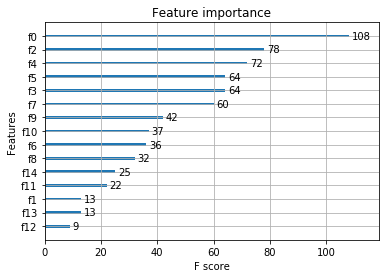

In [59]:
pyplot.figure(figsize=(16,1))
plot_importance(model)
pyplot.show()

In [19]:
dataset.columns

Index(['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct',
       'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'sand_1', 'sand_2', 'sand_3',
       'silt_1', 'silt_2', 'silt_3', 'clay_1', 'clay_2', 'clay_3'],
      dtype='object')

In [ ]:
y_test_inv
y_pred_inv

In [ ]:
abs(min(y_test_inv) - max(y_test_inv))